# Botometer Downloader

**CS109a**: Fall 2018

**Authors**: Gordon Hew, Wenqin Hu, Blair Leduc

**TF**: Ken Arnold

## Botometer checks the Twitter accounts and gives it a score

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# http://www.tweepy.org/
import tweepy
import sys
import jsonpickle
import json
import os
import zipfile
import time
from datetime import date
from sklearn.decomposition import PCA
import math
import botometer

In [3]:
# access botometer #

mashape_key = "HozoY73W3umshiUthQGQaS73C88Np1rXS7tjsnFZ2NrU2lzVmd"
twitter_app_auth = {
'consumer_key': 'fNSZp54j8HgQPqVDZ0UcW1lSl',
'consumer_secret': 'yQ5EvshFjADCV0EWJ02WCMqjn9PnaEuqMKVAyl9H3yuvNyPaUv',
'access_token': '1058713520701882369-3bP6OTKN6ebVYwiLe5Yh43DrZQpPRj',
'access_token_secret': 'RoONmFjQ7kVcUdqQXoiyKye6TBJfwdNFUcZpF0miFNBIa',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

In [4]:
def get_botmeter(IDs):
    accounts = IDs

    botometer_result=[]
    botometer_screen_name=[]

    for screen_name, result in bom.check_accounts_in(accounts):
        botometer_screen_name.append(screen_name)
        botometer_result.append(result)

    
    return (botometer_result, botometer_screen_name)
    

In [6]:
account_df=pd.read_csv('data/random_user_ids.txt', header = None)
print (len(account_df))
account_df.head(1)

1000


,0
0,934576158305345536


In [7]:
accounts = list(account_df[0])
len(accounts)

1000

In [15]:
t = time.time()

botometer_result_1000,botometer_screen_name_1000 \
    = get_botmeter(accounts)

runtime_botometer = time.time()-t 
print('botometer_time: ',runtime_botometer)

botometer_time:  4566.151033878326


In [16]:
with open('data/botometer_result_1000random.json', 'w') as outfile:
    json.dump(botometer_result_1000, outfile)

load botometer scores from file 

In [2]:
def arrange_botometer_score(data_botometer,is_bot):
    account_score = []
    for i in (range(len(data_botometer))):
        for key,val in data_botometer[i].items():
            temp = key 
        if temp != 'error':
            parameters = []
            parameters.append(is_bot)
            for key,val in data_botometer[i]['user'].items():
                parameters.append(val)
            for key,val in data_botometer[i]['categories'].items():
                parameters.append(val)
            for key,val in data_botometer[i]['scores'].items():
                parameters.append(val)
            account_score.append(parameters)

    account_score = pd.DataFrame(account_score)
    account_score.columns = columns = ['is_bot','id','screen_name',
                                       'content','friend','network',
                                       'sentiment','temporal','user',
                                       'score_english','score_universal'
                                      ]
    return account_score

In [3]:
with open('data/botometer_result_1000random.json') as handle:
    human_botometer = json.loads(handle.read())
with open('data/botometer_result_936bot.json') as handle:
    bot_botometer = json.loads(handle.read())

In [4]:
human_score = arrange_botometer_score(human_botometer,is_bot='False')
bot_score = arrange_botometer_score(bot_botometer,is_bot='Ture')

Text(0.5,0.98,'Botometer scores on 936 botwiki and 997 random twitter users')

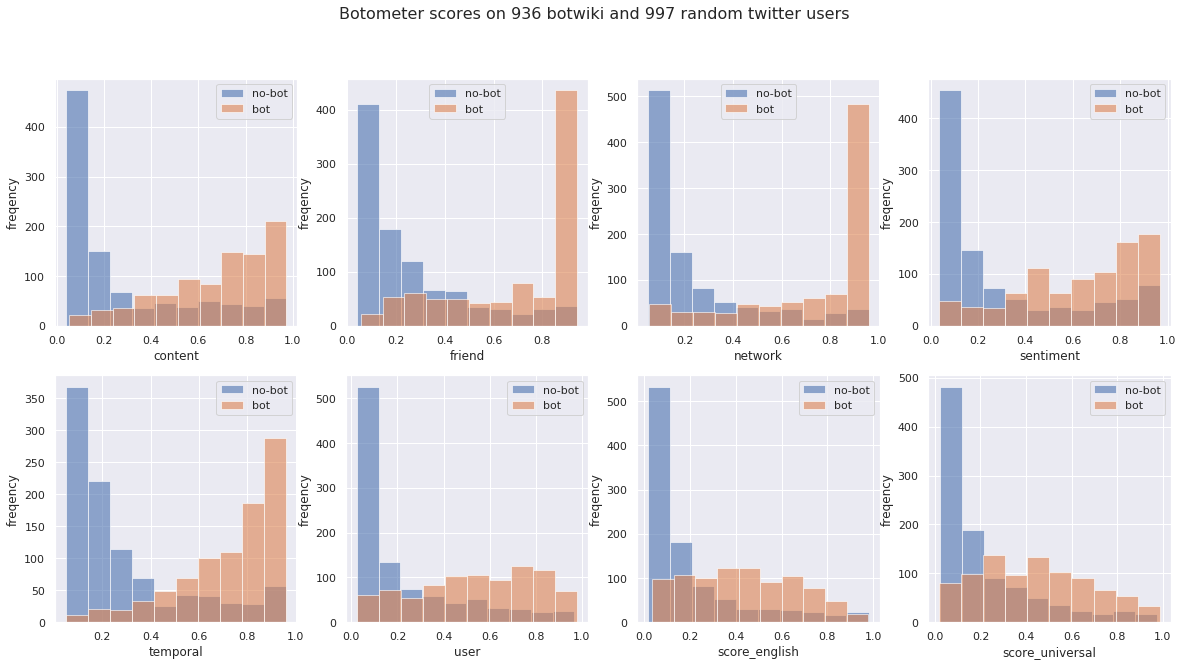

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
col = 3
for j in range(2):
    for i in range(4):
        axs[j,i].hist(human_score.iloc[:,col].tolist(), alpha=0.6, 
                      label='no-bot')
        axs[j,i].hist(bot_score.iloc[:,col].tolist(), alpha=0.6, 
                      label='bot')
        axs[j,i].set_ylabel('freqency') 
        axs[j,i].set_xlabel(human_score.columns[col])
        axs[j,i].legend()
        col=col+1

fig.suptitle("Botometer scores on 936 botwiki "\
             +"and 997 random twitter users", 
             fontsize=16)
        

In [60]:
account_df2 = account_df.copy()
account_df2 = account_df2.drop(columns=['screen_name', 'name', 
                                        'verified', 'location', 
                                        'description', 'lang',
                                        'url', 'geo_enabled', 
                                        'created_at'])
account_df2.head(1)

,id,followers_count,statuses_count,friends_count,favourites_count,listed_count,is_bot,botometer_score
0,37861434,135481,9539,6,0,1591,True,0.341219


In [130]:
y_train = account_df2['is_bot']
x_train = (account_df2.drop(columns=['id', 'is_bot','botometer_score']))
x_train = (x_train+1).apply(np.log, axis=0)

x_train = (x_train - x_train.min())/(x_train.max() - x_train.min())
x_train.describe()

,followers_count,statuses_count,friends_count,favourites_count,listed_count
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.422452,0.435771,0.177962,0.291188,0.366396
std,0.254621,0.232974,0.208065,0.292839,0.225001
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.286515,0.290618,0.000000,0.000000,0.192609
50%,0.410244,0.490280,0.103968,0.238762,0.359801
75%,0.593019,0.590976,0.317226,0.493743,0.498676
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
(x_train+1).head(1)

,followers_count,statuses_count,friends_count,favourites_count,listed_count
0,12.816594,10.163249,2.94591,1.0,8.372746


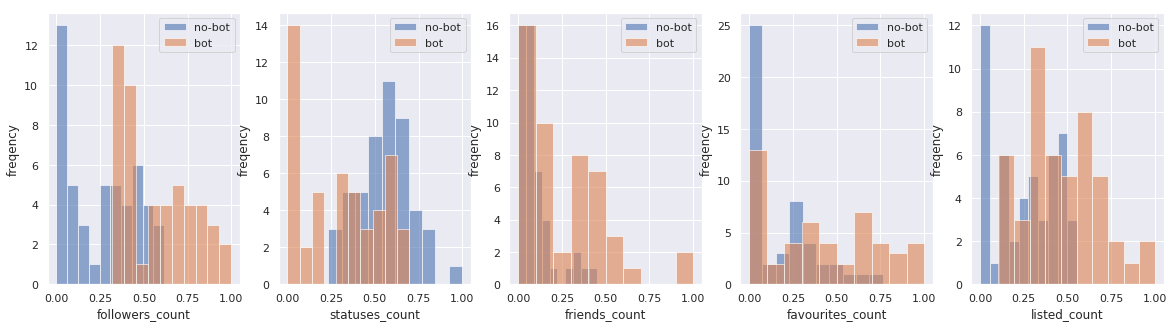

In [131]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axs[i].hist(x_train.iloc[0:49,i].tolist(), alpha=0.6, 
                label='no-bot')
    axs[i].hist(x_train.iloc[50:99,i].tolist(), alpha=0.6, 
                label='bot')        
    axs[i].set_ylabel('freqency') 
    axs[i].set_xlabel(x_train.columns[i])
    axs[i].legend()


Text(0.5,1,'Scatter plot of top 2 components of different types of bot data')

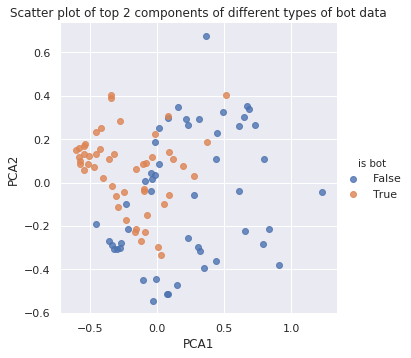

In [135]:
pca = PCA(n_components = 2).fit(x_train)
pca_x = pca.transform(x_train)

pca_df = pd.DataFrame(pca_x, columns=['PCA1', 'PCA2'])
pca_df['is bot'] = y_train.values

sns.lmplot(x="PCA1", y="PCA2", hue='is bot', 
           data=pca_df, fit_reg=False)
plt.title('Scatter plot of top 2 components of '\
          +'different types of bot data')

##  save for laver ##

In [ ]:
tweets_df = pd.read_json(json_file_name, lines=True)
tweets_df.dtypes

bom.check_account(966489271694630912)